In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import folium

In [2]:
import os
os.chdir('../')

In [40]:
from roc_bike_growth.graph_utils import get_street_segment, get_intersections

## Downloading the data as a graph and visualizing

In [4]:
gdf = ox.geocode_to_gdf('rochester, ny')

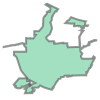

In [5]:
gdf.geometry[0]

In [37]:
# download bike network or load 
GRAPH_PATH = 'data/ROC_network.pickle'

try:
    bike_network = nx.read_gpickle(GRAPH_PATH)
except FileNotFoundError:
    bike_network = ox.graph_from_polygon(gdf.geometry[0], network_type='bike')
    nx.write_gpickle(bike_network, data/ROC_network.pickle) # Write out for later


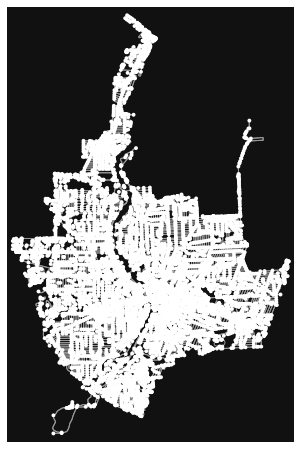

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [39]:
ox.plot.plot_graph(bike_network)

## Visualizing specific streets or segments of streets

To query by attributes like street name, we can download the network as a geodataframe.

In [76]:
tab_form = ox.geometries.geometries_from_polygon(gdf.geometry[0],tags={'highway':True})

### `street` like Broad St

The [TIGER](https://wiki.openstreetmap.org/wiki/TIGER) attributes seem to be the most useful for this type of query.

In [41]:
broad_street = tab_form[tab_form['tiger:name_base']=='Broad']

NameError: name 'tab_form' is not defined

In [231]:
m = folium.Map(location=[43.15, -77.6750], tiles="Stamen Toner", zoom_start=13)

folium.GeoJson(broad_street[['name','geometry']].to_json(), name='Broad Street'
).add_to(m)

In [232]:
m

## Intersection of Broad and Allen

In [235]:
allen_street = tab_form[tab_form['tiger:name_base']=='Allen']

In [236]:
first_intersection = broad_street.sjoin(allen_street[['geometry','name']], how='inner', rsuffix='r').iloc[0]

In [285]:
first_intersection

highway                                               primary
geometry    LINESTRING (-77.6252208 43.1581155, -77.625149...
ref                                                     NY 31
railway                                                   NaN
old_ref                                                   NaN
                                  ...                        
ways                                                      NaN
type                                                      NaN
index_r0                                                  way
index_r1                                             68312333
name_r                                           Allen Street
Name: (way, 597508984), Length: 189, dtype: object

In [237]:
intersection_point = (
    first_intersection.geometry.intersection(
        allen_street.loc[(first_intersection['index_r0'], first_intersection['index_r1']),:].geometry))

In [233]:
folium.Marker(location=(intersection_point.coords[0][1],intersection_point.coords[0][0]) , name='Allen St. Intersection'
).add_to(m)

In [234]:
m

### Broad St, between Smith and Allen

Many of the reccommended enhancements are posed in this way, for example in the Bikeable Cities report, they provide a list of priorities:

> 
> - Broad St between Smith and Allen – 32 feet wide, on-street parking present
> - Genesee St south of Melrose – 43 feet wide, on-street parking present
> - Portland Ave between North and Central Park – 43 feet wide, on-street parking present
> - Monroe Ave between Howell and Alexander – 43 feet wide, on-street parking present
> - Monroe Avenue east of Goodman Street – 46 feet wide, on- street parking present

After some digging, I think this is best done by iterating through the graph, rather than the GDF. Check out `graph_utils.py` to see `get_street_segement()`. 

In [42]:
segments = [ # street, src_intersection, dest_intersection
    ('broad street', 'smith street', 'allen street'),
    ('genesee street', 'melrose street', 'elmwood avenue'),
    ('portland avenue', 'north street', 'central park'),
    ('monroe avenue', 'howell street', 'alexander street'),
    ('monroe avenue', 'goodman street', 'highland avenue')]

routes = []
for street, src, dest in segments:
    routes.append(get_street_segment(bike_network, street, src, dest))

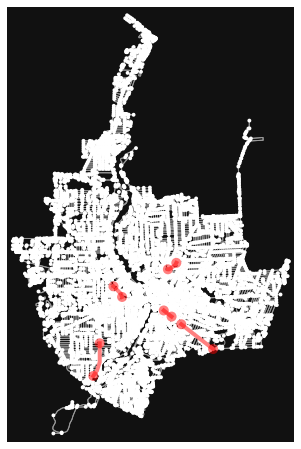

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [49]:
ox.plot.plot_graph_routes(bike_network, routes)

In [46]:
m = folium.Map(location=[43.15, -77.6750], tiles="Stamen Toner", zoom_start=13)
[ox.folium.plot_route_folium(bike_network, route, m) for route in routes]

In [86]:
len(bike_network.nodes())

11267

In [47]:
m